In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import cv2
import glob as gb
import tensorflow as tf
from keras import layers, models
from keras.datasets import cifar10
from keras.applications import ResNet152V2, VGG16, VGG19, InceptionV3, EfficientNetB7
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from keras.models import Model, Sequential, load_model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, recall_score, precision_score, f1_score,roc_curve,auc
from sklearn.preprocessing import label_binarize, LabelEncoder
from keras.losses import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
from PIL import Image
import keras.backend as K

In [2]:
import sys
import os

code_folder = r'D:/Corrosion detection/Corrosion Detection/Code'
sys.path.append(code_folder)

from ImageProcessor import ImageReader, ImageLoading,ImageAugmentation
from Model import ModelTrainer,ModelArchitectures 
from ModelEvaluator import ModelEvaluator

In [3]:
train_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Training/Object'
test_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Testing/Object'
pred_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Pred'
augmented_train_path = 'D:/Corrosion detection/Corrosion Detection/Dataset/Augmented_Training/Object'

In [4]:
# Initialize ImageReader instances
image_reader_train = ImageReader(train_path)
image_reader_test = ImageReader(test_path)

# Count images in folders for each set (1st and 2nd datasets)
image_reader_train.count_images_in_folders('training', is_subfolder=True)
image_reader_test.count_images_in_folders('testing', is_subfolder=True)


# Get image sizes for each dataset
print("Image sizes for Training Dataset:")
print(image_reader_train.get_image_sizes(is_subfolder=True))

print("Image sizes for Testing Dataset:")
print(image_reader_test.get_image_sizes(is_subfolder=True))

For training data, found 112 images in folder "Flanges".
For training data, found 175 images in folder "Pipeline".
For testing data, found 30 images in folder "Flanges".
For testing data, found 30 images in folder "Pipeline".
Image sizes for Training Dataset:
(896, 896, 3)      202
(894, 894, 3)       73
(897, 897, 3)        5
(504, 504, 3)        1
(1038, 1038, 3)      1
(288, 288, 3)        1
(868, 900, 3)        1
(900, 900, 3)        1
(734, 896, 3)        1
(898, 898, 3)        1
Name: count, dtype: int64
Image sizes for Testing Dataset:
(896, 896, 3)    51
(894, 894, 3)     8
(504, 504, 3)     1
Name: count, dtype: int64


In [5]:
# Initialize ImageAugmentation instances
image_augmentation = ImageAugmentation(train_path, augmented_train_path, target_count=1000,image_size=(224, 224))

# Perform augmentation for dataset
image_augmentation.augment_all_classes()

Processing class: Flanges
Class Flanges has 112 images. 1000 needed.
Augmentation completed for Flanges: 1000 images added.
Augmentation completed for Flanges: 1000 images added.
Processing class: Pipeline
Class Pipeline has 175 images. 1000 needed.
Augmentation completed for Pipeline: 1000 images added.
Augmentation completed for Pipeline: 1000 images added.


In [4]:
image_loader = ImageLoading()

In [5]:
train_code = {0: "Flanges", 1: "Pipeline" }

In [6]:
x_train, y_train = image_loader.load_images(augmented_train_path, code=train_code, is_subfolder=True)
x_test, y_test = image_loader.load_images(test_path, code=train_code, is_subfolder=True)

In [7]:
# Shuffle the test dataset
x_test_shuffled, y_test_shuffled = image_loader.shuffle_data(x_test, y_test)

In [8]:
class_labels = np.unique(y_train)

In [9]:
model_checkpoint ='D:/Corrosion detection/Corrosion Detection/models/Object'

In [11]:
model_arch = ModelArchitectures(input_shape=(224, 224, 3), weights='imagenet')

models_dict = {
    'VGG16': model_arch.vgg16,
    'VGG19': model_arch.vgg19,
    'ResNet152V2': model_arch.resnet152v2,
    'InceptionV3': model_arch.inception_v3,
    'EfficientNetB0': model_arch.efficientnet
}

In [13]:
model_trainer = ModelTrainer(
    models=models_dict,
    class_labels=class_labels,
    train_data=(x_train, y_train),
    val_data=(x_test, y_test), 
    test_data=(x_test, y_test), 
    epochs=10,  # Set the number of epochs
    batch_size=32,  # Set the batch size to 8
    checkpoint_path="model_checkpoint.keras"
)

Training VGG16...

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7959 - loss: 5.6723
Epoch 1: val_accuracy improved from -inf to 0.81538, saving model to model_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.7971 - loss: 5.6494 - val_accuracy: 0.8154 - val_loss: 2.2333 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9285 - loss: 1.5374
Epoch 2: val_accuracy improved from 0.81538 to 0.93846, saving model to model_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 240s 4s/step - accuracy: 0.9285 - loss: 1.5324 - val_accuracy: 0.9385 - val_loss: 0.8813 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9279 - loss: 0.6319
Epoch 3: val_accuracy did not improve from 0.93846
63/63 ━━━━━━━━━━━━━━━━━

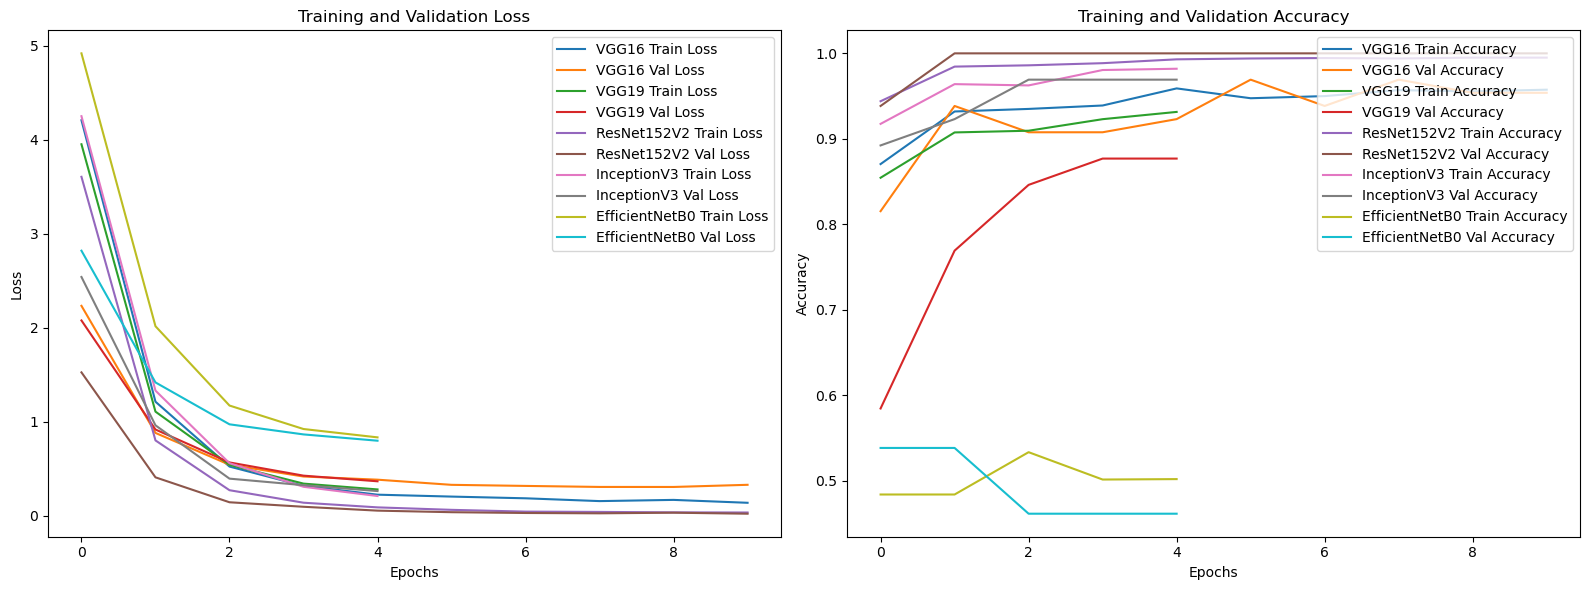

In [13]:
model_trainer.train_and_evaluate_all_models()

In [12]:
ResNet_dict = {
    'ResNet152V2': model_arch.resnet152v2,
}

In [13]:
ResNet_trainer = ModelTrainer(
    models=ResNet_dict,
    class_labels=class_labels,
    train_data=(x_train, y_train),
    val_data=(x_test_shuffled, y_test_shuffled), 
    test_data=(x_test, y_test), 
    epochs=5,  # Set the number of epochs
    batch_size=32,  
    checkpoint_path="model_checkpoint.h5"
)

Training ResNet152V2...
Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8921 - loss: 5.5101
Epoch 1: val_accuracy improved from -inf to 0.90000, saving model to model_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 351s 5s/step - accuracy: 0.8929 - loss: 5.4875 - val_accuracy: 0.9000 - val_loss: 1.9568 - learning_rate: 0.0010
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9807 - loss: 1.3723
Epoch 2: val_accuracy improved from 0.90000 to 0.95000, saving model to model_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.9806 - loss: 1.3676 - val_accuracy: 0.9500 - val_loss: 0.6503 - learning_rate: 0.0010
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9847 - loss: 0.4989
Epoch 3: val_accuracy improved from 0.95000 to 0.96667, saving model to model_checkpoint.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 312s 5s/step - accuracy: 0.9847 - loss: 0.4980 - val_accuracy: 0.9667 - val_loss: 0.3673 - learning_rate: 5.0000e-04
Epoch 4/5
63/63 ━━━━━━━━

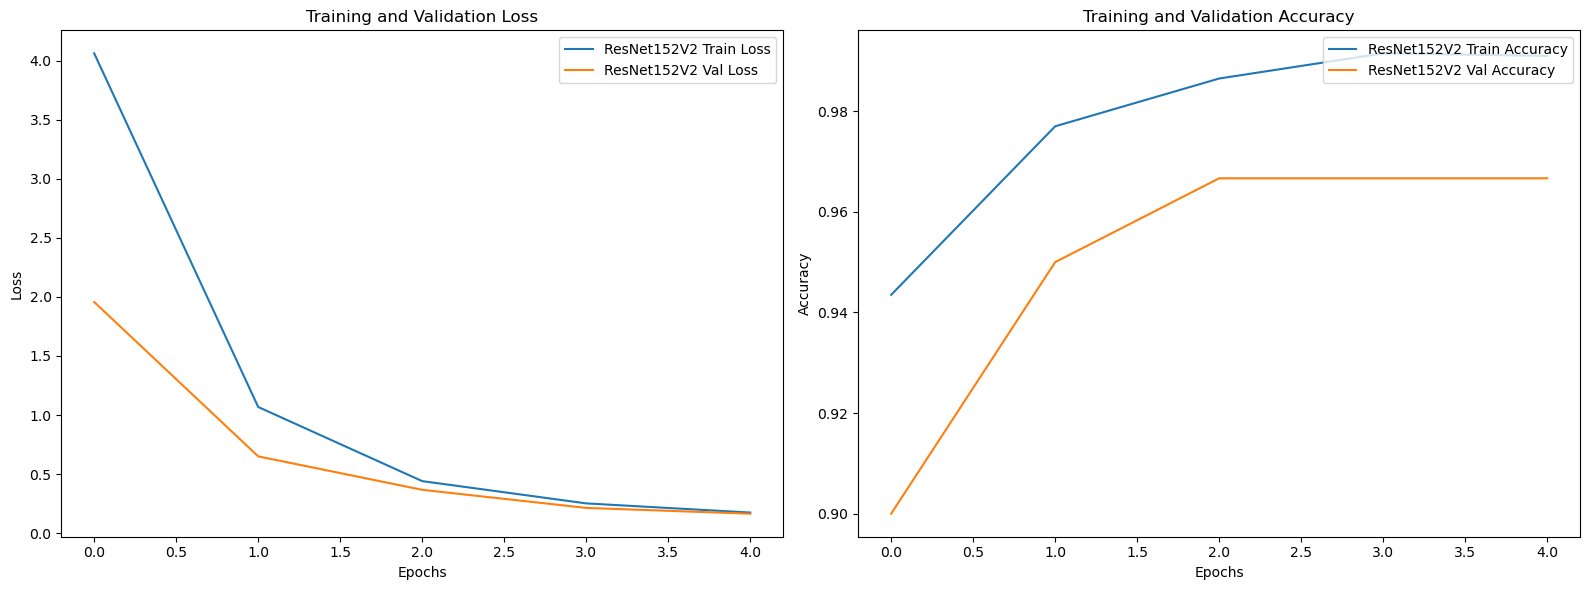

In [13]:
ResNet_trainer.train_and_evaluate_all_models()

Training ResNet152V2...


Epoch 1/5


63/63 [==============================] - ETA: 0s - loss: 1.0153 - accuracy: 0.9395
Epoch 1: val_accuracy improved from -inf to 0.93333, saving model to model_checkpoint.h5


c:\ProgramData\anaconda3\envs\corrosion\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


63/63 [==============================] - 253s 4s/step - loss: 1.0153 - accuracy: 0.9395 - val_loss: 0.9770 - val_accuracy: 0.9333 - lr: 4.0000e-04
Epoch 2/5
63/63 [==============================] - ETA: 0s - loss: 0.8335 - accuracy: 0.9835
Epoch 2: val_accuracy improved from 0.93333 to 0.96667, saving model to model_checkpoint.h5
63/63 [==============================] - 229s 4s/step - loss: 0.8335 - accuracy: 0.9835 - val_loss: 0.7834 - val_accuracy: 0.9667 - lr: 4.0000e-04
Epoch 3/5
63/63 [==============================] - ETA: 0s - loss: 0.7269 - accuracy: 0.9940
Epoch 3: val_accuracy improved from 0.96667 to 0.98333, saving model to model_checkpoint.h5
63/63 [==============================] - 227s 4s/step - loss: 0.7269 - accuracy: 0.9940 - val_loss: 0.6952 - val_accuracy: 0.9833 - lr: 4.0000e-04
Epoch 4/5
63/63 [==============================] - ETA: 0s - loss: 0.6480 - accuracy: 0.9950
Epoch 4: val_accuracy did not improve from 0.98333
63/63 [==============================] - 225s

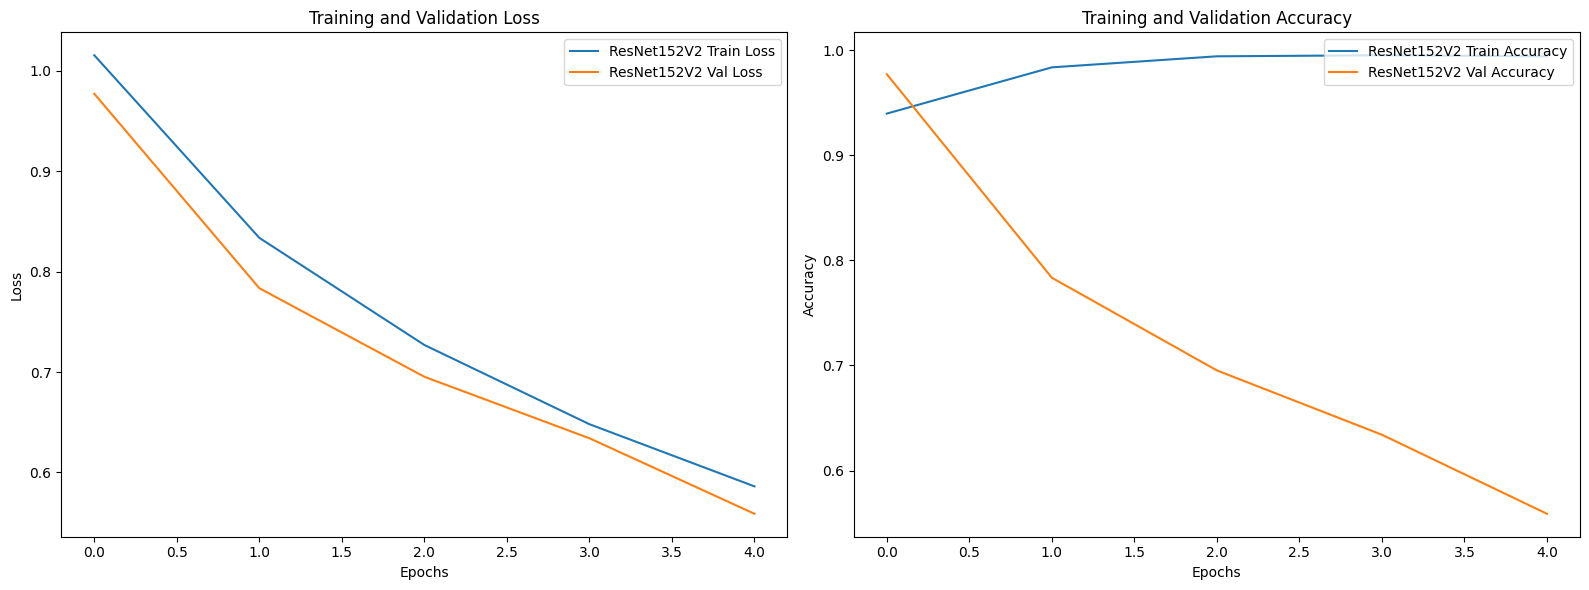

In [14]:
ResNet_trainer.train_and_evaluate_all_models()